# Asesment of treatment effect on proband P387 Cells
### Famliy 4 - PB000188 - c.1824C>T LMNA
### All Feature or AreaShape Features only - Normalized on M388 Mother cells with DMSO
### https://imagedb.k8s-prod.pharmb.io/?barcode=PB000188&acqid=5538#
### P387 Proband Diseased, M388 Mother Healthy, F389 Father Healthy
### HY-15136 = Lonafarnib, HY-15315 = Baricitinib
#### 2025-11-22 MMJ

In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import matplotlib.patches as mpatches
from matplotlib.patches import Patch
import re
import os
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap
from sklearn.ensemble import IsolationForest
#import warnings
#warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")

In [126]:
os.getcwd()

'/share/data/analyses/martin/036_Progeria_LoBa_48h_72h/004_analysis/PB000188_LoBa_72h_family4_PCA_tSNE_median/Classification_results_kasta/004_analysis/PB000188_LoBa_72h_family4_PCA_tSNE_median/Classification_results_kasta'

### Setting up folder for output

In [127]:
folder_name = "Classification_results_kasta"
new_folder = os.path.join(os.getcwd(), "004_analysis", "PB000188_LoBa_72h_family4_PCA_tSNE_median", folder_name)
os.makedirs(new_folder, exist_ok=True)
print("Created folder:", new_folder)
os.chdir(new_folder)

Created folder: /share/data/analyses/martin/036_Progeria_LoBa_48h_72h/004_analysis/PB000188_LoBa_72h_family4_PCA_tSNE_median/Classification_results_kasta/004_analysis/PB000188_LoBa_72h_family4_PCA_tSNE_median/Classification_results_kasta/004_analysis/PB000188_LoBa_72h_family4_PCA_tSNE_median/Classification_results_kasta


### Setting up variables

In [128]:
plate = 'PB000188'
features = 'all_features' # AreaShape
normalization = 'M388'
family = 'family4'
print(plate)
print(features)
print(normalization)
print(family)

PB000188
all_features
M388
family4


### Loading data

In [129]:
#data = pd.read_csv('/share/data/analyses/martin/036_Progeria_LoBa_48h_72h/004_analysis/PB000188_LoBa_72h_family4_PCA_tSNE_median_M388_norm_AreaShape/data_for_ml/dfZscores Progeria PB000188 LoBa 72h family 4 Zscores normalized on PHB000001_M388 All Features.csv') # AreaShape features only
data = pd.read_csv('/share/data/analyses/martin/036_Progeria_LoBa_48h_72h/004_analysis/PB000188_LoBa_72h_family4_PCA_tSNE_median/dfZscores Progeria PB000188 LoBa 72h family 4 Zscores normalized on PHB000001_M388 All Features.csv') # All Features
data.head(2)

,WellID,plate,batch_id,person_plate,comp_conc,AreaShape_Area_nuclei,AreaShape_BoundingBoxArea_nuclei,AreaShape_BoundingBoxMaximum_X_nuclei,AreaShape_BoundingBoxMaximum_Y_nuclei,AreaShape_BoundingBoxMinimum_X_nuclei,...,RadialDistribution_ZernikePhase_illumSYTO_8_2_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_8_4_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_8_6_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_8_8_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_1_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_3_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_5_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_7_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_9_cytoplasm,Count_nuclei
0,PB000188_A02,PB000188,HY-15315,M388_PB000188,HY-15315_0.1,0.141392,0.071453,-0.076210,0.700024,-0.094550,...,-0.441912,-0.053947,-0.377570,-0.032348,0.574303,0.194226,-0.151270,-0.693074,0.193689,-0.393780
1,PB000188_A03,PB000188,HY-15136,P387_PB000188,HY-15136_4.0,9.026772,9.000279,2.167414,-1.295590,2.211243,...,-0.587930,1.238131,1.294947,-0.631829,-1.999400,1.404031,2.141365,-1.479475,3.480793,-2.306426


### Dropping count_nuclei (especially since proband wells have less cells in DMSO treatment)

In [130]:
data = data.drop(columns=['Count_nuclei'], errors='ignore')

### Selecting cytoplasm or nuclei specific features

In [131]:
feature_filtering = 'cytoplasmic' # 'nuclei'  'none'  'cytoplasmic'
feature_filtering

'cytoplasmic'

In [132]:
if feature_filtering == 'nuclei':
    first_columns = data.iloc[:, :5]
    nuclei_columns = [col for col in data.columns if 'nuclei' in col]
    print("Number of nuclei features retained:", len(nuclei_columns))
    data = data[nuclei_columns]
    
    # Add the first columns to data again
    data = pd.concat([first_columns, data], axis=1)   
    print("Data contains features with nuclei in their name.")
    print("data:", data.shape)
    
elif feature_filtering == 'cytoplasmic':
    first_columns = data.iloc[:, :5]  
    cytoplasm_columns = [col for col in data.columns if 'cytoplasm' in col] # not in col WHEN USING NEGATIVE SELECTION
    print("Number of non-nuclei features retained:", len(cytoplasm_columns))
    data = data[cytoplasm_columns]
    
    # Add the last columns to data again
    data = pd.concat([first_columns, data], axis=1)
    print("Data contains features with cytoplasm.")
    print("data:", data.shape)   
    
else:
        print("No filtering was done to data:", data.shape)

Number of non-nuclei features retained: 640
Data contains features with cytoplasm.
data: (253, 645)


In [133]:
#count_instances= data.columns.str.contains("correlation", case=False).sum()
#count_instances
#data.head(3)

### Checking outliers

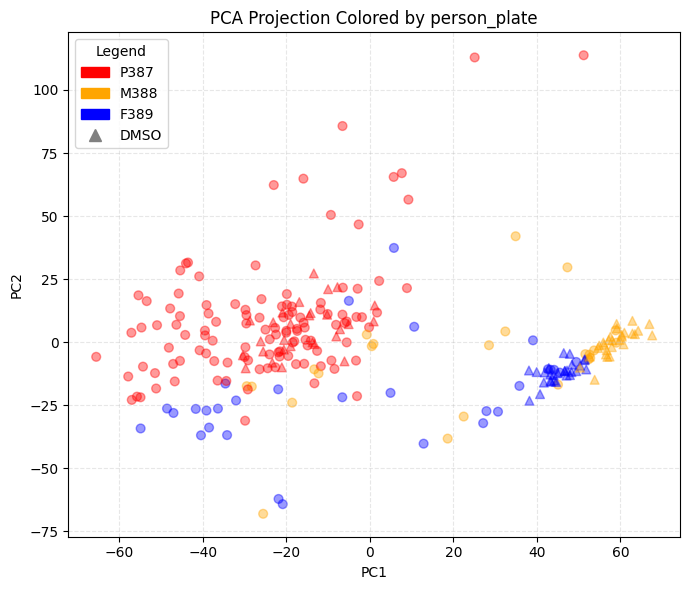

In [134]:
X = data.select_dtypes(include=[np.number]).fillna(0)

pca = PCA(n_components=2)
pc = pca.fit_transform(X)

# Extract person_plate
pp = data["person_plate"].astype(str)

# Map to colors
color_map = {"P387": "red", "M388": "orange", "F389": "blue"}
colors = pp.apply(lambda x: color_map.get(x.split("_")[0], "gray"))

# Identify which points should be visualized as triangles (control DMSO)
mask_tri = data["comp_conc"].astype(str).str.contains("PHB000001", case=False)

# PCA plot
plt.figure(figsize=(7,6))

# Circles (normal compounds)
plt.scatter(pc[~mask_tri, 0], pc[~mask_tri, 1], c=colors[~mask_tri], alpha=0.4, edgecolor=colors[~mask_tri], s=40, marker="o")

# Triangles (PHB000001 → DMSO)
plt.scatter(pc[mask_tri, 0], pc[mask_tri, 1], c=colors[mask_tri], alpha=0.4, edgecolor=colors[mask_tri], s=40, marker="^",label="DMSO")

plt.title("PCA Projection Colored by person_plate")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True, linestyle="--", alpha=0.3)

# Legend (add triangle explanation)
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_patches = [
    Patch(color="red", label="P387"),
    Patch(color="orange", label="M388"),
    Patch(color="blue", label="F389"),
    Line2D([0], [0], marker="^", color="w", markerfacecolor="gray",
           markeredgecolor="gray", markersize=8, label="DMSO")]

plt.legend(handles=legend_patches, title="Legend")

plt.tight_layout()
plt.savefig("PCA_{}_normalized_on_{}_{}.png".format(plate, normalization, features), dpi=200, bbox_inches='tight')
plt.show()


Number of outliers detected 3


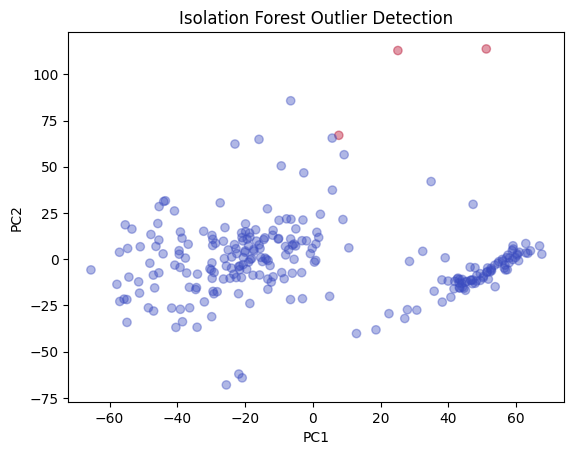

In [135]:
X = data.select_dtypes(include=[np.number]).fillna(0)

iso = IsolationForest(contamination=0.01, random_state=42)
labels = iso.fit_predict(X)     # -1 = outlier, 1 = normal

outlier_idx = np.where(labels == -1)[0]
print("Number of outliers detected",len(outlier_idx))
plt.scatter(pc[:,0], pc[:,1], c=(labels==-1), cmap='coolwarm', alpha=0.4)
plt.title("Isolation Forest Outlier Detection")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

### Listing outlier wells 

In [136]:
outlier_rows = data.iloc[outlier_idx]
outlier_rows

,WellID,plate,batch_id,person_plate,comp_conc,AreaShape_Area_cytoplasm,AreaShape_BoundingBoxArea_cytoplasm,AreaShape_BoundingBoxMaximum_X_cytoplasm,AreaShape_BoundingBoxMaximum_Y_cytoplasm,AreaShape_BoundingBoxMinimum_X_cytoplasm,...,RadialDistribution_ZernikePhase_illumSYTO_8_0_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_8_2_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_8_4_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_8_6_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_8_8_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_1_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_3_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_5_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_7_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_9_cytoplasm
22,PB000188_B12,PB000188,PHB000015,P387_PB000188,PHB000015_3.0,6.875949,5.478952,-2.229218,-0.161734,-2.806776,...,0.0,0.675020,2.323134,-3.777612,-1.964226,1.770378,-1.831011,-0.134617,0.553978,-1.879121
86,PB000188_F03,PB000188,PHB000006,P387_PB000188,PHB000006_10.0,2.463992,-2.562793,-2.235432,0.245711,-2.656279,...,0.0,-0.349852,-0.483754,3.398403,-2.126001,-4.282354,-2.693599,4.329252,4.252047,-3.731882
164,PB000188_K03,PB000188,PHB000002,P387_PB000188,PHB000002_1.0,-3.190509,-3.380350,-0.905668,2.923647,-0.976728,...,-20.0,-1.312251,-3.688544,0.711553,0.164209,-0.375141,1.302194,-0.515963,-2.763626,2.335314


### All compounds in dataset

In [137]:
#list(data.comp_conc.unique())

### Control compounds

In [138]:
# ["PHB000016", "PHB000018", "PHB000004", "PHB000010", "PHB000008",  "PHB000019", "PHB000012", "PHB000002", "PHB000015", "PHB000006"]

### Baricitinib & Lonafarnib

In [139]:
#["HY-15315", "HY-15136"]

### DMSO

In [140]:
#["PHB000001"]

### Retain DMSO, Lonafarnib and Baricitinib treatments

In [141]:
compounds_to_keep = ['PHB000001', 'HY-15136', 'HY-15315'] # , 'HY-15136' Baricitinib, 'HY-15315' Lonafarnib
#compounds_to_keep = ["PHB000016", "PHB000018", "PHB000004", "PHB000010", "PHB000008",  "PHB000019", "PHB000012", "PHB000002", "PHB000015"] # 'PHB000001', 'HY-15136', 'HY-15315'
#compounds_to_keep = ["PHB000016", "PHB000018", "PHB000004", "PHB000010", "PHB000008",  "PHB000019", "PHB000012", "PHB000002", "PHB000015", 'PHB000001', 'HY-15136', 'HY-15315']
#data_treatments = data[~data['comp_conc'].str.contains('|'.join(compounds_to_keep))] # EXCLUDE
data_treatments = data[data['comp_conc'].str.contains('|'.join(compounds_to_keep))] # INCLUDE
data_treatments

,WellID,plate,batch_id,person_plate,comp_conc,AreaShape_Area_cytoplasm,AreaShape_BoundingBoxArea_cytoplasm,AreaShape_BoundingBoxMaximum_X_cytoplasm,AreaShape_BoundingBoxMaximum_Y_cytoplasm,AreaShape_BoundingBoxMinimum_X_cytoplasm,...,RadialDistribution_ZernikePhase_illumSYTO_8_0_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_8_2_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_8_4_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_8_6_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_8_8_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_1_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_3_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_5_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_7_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_9_cytoplasm
0,PB000188_A02,PB000188,HY-15315,M388_PB000188,HY-15315_0.1,0.781922,1.036658,-0.153793,1.598675,0.320559,...,0.0,-0.441912,-0.053947,-0.377570,-0.032348,0.574303,0.194226,-0.151270,-0.693074,0.193689
1,PB000188_A03,PB000188,HY-15136,P387_PB000188,HY-15136_4.0,4.122417,0.219324,0.908775,-1.835055,0.835260,...,-20.0,-0.587930,1.238131,1.294947,-0.631829,-1.999400,1.404031,2.141365,-1.479475,3.480793
2,PB000188_A04,PB000188,PHB000001,P387_PB000188,PHB000001_0.1,12.191764,5.517065,0.646240,-0.614277,0.440957,...,0.0,-0.851160,0.161159,-0.169089,1.692752,1.701895,-0.481200,1.177919,0.591259,1.150220
8,PB000188_A11,PB000188,HY-15136,F389_PB000188,HY-15136_10.0,20.000000,14.794941,-0.936737,-0.244156,-1.452300,...,-10.0,-2.489510,-0.014791,-1.875552,-0.735757,1.527274,-0.739999,-0.540417,-0.386128,-2.744867
9,PB000188_A12,PB000188,HY-15136_HY-15315,P387_PB000188,HY-15136_HY-15315_4.0_1.0,9.009601,2.992717,3.242075,-1.887929,2.990383,...,0.0,-0.737458,-0.785404,1.599424,0.569421,-0.477284,1.523647,-2.334472,-0.902438,-1.461331
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,PB000188_P11,PB000188,PHB000001,F389_PB000188,PHB000001_0.1,3.322182,2.617356,0.604297,0.466539,0.582425,...,0.0,-0.550758,0.134695,0.499864,0.251764,0.568851,-0.264038,-0.443720,0.097568,0.395974
247,PB000188_P12,PB000188,PHB000001,P387_PB000188,PHB000001_0.1,14.713711,10.050112,1.098298,0.273703,0.519216,...,0.0,-0.289671,-0.297352,-1.280358,-0.710582,1.023632,-0.608396,0.534028,0.751409,0.771385
249,PB000188_P16,PB000188,HY-15315,P387_PB000188,HY-15315_0.1,2.837450,0.622557,-1.475789,-1.747968,-1.357486,...,0.0,-0.606497,0.377810,-0.632330,0.990799,-1.220235,-0.706761,-0.964250,-0.734070,-1.568531
250,PB000188_P17,PB000188,PHB000001,F389_PB000188,PHB000001_0.1,4.224417,3.903503,0.153793,0.283034,-0.022575,...,0.0,-0.168328,-0.074389,-0.050491,-1.251943,-0.824591,-0.027806,-0.083641,0.240349,-0.371256


### Checking number of wells per person

In [142]:
counts = data['person_plate'].str[:4].value_counts().loc[['P387', 'M388', 'F389']]
counts

person_plate
P387    144
M388     51
F389     58
Name: count, dtype: int64

### Select what subjects to keep for training the model

In [143]:
persons_to_keep = ['P387', 'M388'] # 'M388' 'F389'
data_treatments_ready = data_treatments[data_treatments['person_plate'].str.contains('|'.join(persons_to_keep))]
data_treatments_ready

,WellID,plate,batch_id,person_plate,comp_conc,AreaShape_Area_cytoplasm,AreaShape_BoundingBoxArea_cytoplasm,AreaShape_BoundingBoxMaximum_X_cytoplasm,AreaShape_BoundingBoxMaximum_Y_cytoplasm,AreaShape_BoundingBoxMinimum_X_cytoplasm,...,RadialDistribution_ZernikePhase_illumSYTO_8_0_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_8_2_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_8_4_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_8_6_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_8_8_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_1_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_3_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_5_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_7_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_9_cytoplasm
0,PB000188_A02,PB000188,HY-15315,M388_PB000188,HY-15315_0.1,0.781922,1.036658,-0.153793,1.598675,0.320559,...,0.0,-0.441912,-0.053947,-0.377570,-0.032348,0.574303,0.194226,-0.151270,-0.693074,0.193689
1,PB000188_A03,PB000188,HY-15136,P387_PB000188,HY-15136_4.0,4.122417,0.219324,0.908775,-1.835055,0.835260,...,-20.0,-0.587930,1.238131,1.294947,-0.631829,-1.999400,1.404031,2.141365,-1.479475,3.480793
2,PB000188_A04,PB000188,PHB000001,P387_PB000188,PHB000001_0.1,12.191764,5.517065,0.646240,-0.614277,0.440957,...,0.0,-0.851160,0.161159,-0.169089,1.692752,1.701895,-0.481200,1.177919,0.591259,1.150220
9,PB000188_A12,PB000188,HY-15136_HY-15315,P387_PB000188,HY-15136_HY-15315_4.0_1.0,9.009601,2.992717,3.242075,-1.887929,2.990383,...,0.0,-0.737458,-0.785404,1.599424,0.569421,-0.477284,1.523647,-2.334472,-0.902438,-1.461331
10,PB000188_A13,PB000188,HY-15315,P387_PB000188,HY-15315_10.0,20.000000,14.853348,1.946488,0.351460,0.823221,...,0.0,0.178994,-1.004965,-1.797041,0.012284,3.606818,1.476790,-1.343740,-0.295572,3.292606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,PB000188_P02,PB000188,PHB000001,M388_PB000188,PHB000001_0.1,1.332605,1.812664,-0.436523,0.181950,-0.424403,...,0.0,0.065383,-0.351342,0.103359,-1.140023,-0.406874,0.067002,-0.176213,0.722395,-0.155679
244,PB000188_P08,PB000188,HY-15315,M388_PB000188,HY-15315_30.0,20.000000,18.973292,3.145760,0.510083,0.564365,...,0.0,1.283850,2.704697,2.378807,-4.706472,-0.074204,-3.925724,-2.274829,0.291526,-0.486801
247,PB000188_P12,PB000188,PHB000001,P387_PB000188,PHB000001_0.1,14.713711,10.050112,1.098298,0.273703,0.519216,...,0.0,-0.289671,-0.297352,-1.280358,-0.710582,1.023632,-0.608396,0.534028,0.751409,0.771385
249,PB000188_P16,PB000188,HY-15315,P387_PB000188,HY-15315_0.1,2.837450,0.622557,-1.475789,-1.747968,-1.357486,...,0.0,-0.606497,0.377810,-0.632330,0.990799,-1.220235,-0.706761,-0.964250,-0.734070,-1.568531


### Checking treatment replicates combined in P387 & M388

In [144]:
#counts_trt = data_treatments_ready['comp_conc'].value_counts()
#counts_trt

### Replicates in treatments per person

In [145]:
replicate_counts = (
    data_treatments_ready
    .assign(person_prefix=data_treatments_ready['person_plate'].str[:4])
    .groupby(['person_prefix', 'comp_conc'])
    .size()
    .reset_index(name='replicates'))
replicate_counts

,person_prefix,comp_conc,replicates
0,M388,HY-15136_0.1,2
1,M388,HY-15136_0.4,2
2,M388,HY-15136_1.0,2
3,M388,HY-15136_10.0,2
4,M388,HY-15136_4.0,2
5,M388,HY-15315_0.1,2
6,M388,HY-15315_0.4,2
7,M388,HY-15315_1.0,2
8,M388,HY-15315_10.0,2
9,M388,HY-15315_30.0,1


# # Setting up data for modeling P387 in DMSO and M388 in DMSO only 

In [146]:
data_P387_M388_dmso = data_treatments_ready[data_treatments_ready['comp_conc'] == 'PHB000001_0.1']
data_P387_M388_dmso = data_P387_M388_dmso.sort_values(by='person_plate')
print("Unique compounds in data: ",data_P387_M388_dmso.comp_conc.unique()) # DMSO = 'PHB000001_0.1'
data_P387_M388_dmso.head()

Unique compounds in data:  ['PHB000001_0.1']


,WellID,plate,batch_id,person_plate,comp_conc,AreaShape_Area_cytoplasm,AreaShape_BoundingBoxArea_cytoplasm,AreaShape_BoundingBoxMaximum_X_cytoplasm,AreaShape_BoundingBoxMaximum_Y_cytoplasm,AreaShape_BoundingBoxMinimum_X_cytoplasm,...,RadialDistribution_ZernikePhase_illumSYTO_8_0_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_8_2_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_8_4_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_8_6_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_8_8_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_1_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_3_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_5_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_7_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_9_cytoplasm
252,PB000188_P20,PB000188,PHB000001,M388_PB000188,PHB000001_0.1,1.675811,1.477228,-0.433416,-0.167954,-0.091803,...,0.0,0.189463,-1.261453,-0.146058,-0.019311,-0.482226,-0.387860,-0.549297,-0.666058,-0.169248
154,PB000188_J08,PB000188,PHB000001,M388_PB000188,PHB000001_0.1,-0.722576,-0.312997,0.020195,-0.068426,-0.127923,...,0.0,-0.352943,-0.300913,-0.371697,-0.516412,-0.533051,-0.031216,-0.438378,-0.251742,-0.151396
149,PB000188_J02,PB000188,PHB000001,M388_PB000188,PHB000001_0.1,0.602031,0.347081,0.849744,0.329688,1.172375,...,0.0,0.692907,0.332960,-0.268262,-0.066489,0.485527,-0.035734,0.384956,0.103455,-0.646204
145,PB000188_I20,PB000188,PHB000001,M388_PB000188,PHB000001_0.1,1.147498,0.728430,0.206610,-1.082371,0.281430,...,0.0,0.003524,-0.329766,1.030397,0.645183,-0.067307,-0.189059,0.729241,0.200844,0.059054
184,PB000188_L08,PB000188,PHB000001,M388_PB000188,PHB000001_0.1,-0.104782,-0.140141,-0.815567,0.248821,-0.922549,...,0.0,0.185266,0.400997,1.639409,-0.225473,-0.382399,-0.356669,0.839521,-0.567900,-0.870764


### This data is now ready for training models

In [147]:
print("Unique compounds in data", data_P387_M388_dmso.comp_conc.unique())
data_P387_M388_dmso.head(2)

Unique compounds in data ['PHB000001_0.1']


,WellID,plate,batch_id,person_plate,comp_conc,AreaShape_Area_cytoplasm,AreaShape_BoundingBoxArea_cytoplasm,AreaShape_BoundingBoxMaximum_X_cytoplasm,AreaShape_BoundingBoxMaximum_Y_cytoplasm,AreaShape_BoundingBoxMinimum_X_cytoplasm,...,RadialDistribution_ZernikePhase_illumSYTO_8_0_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_8_2_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_8_4_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_8_6_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_8_8_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_1_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_3_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_5_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_7_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_9_cytoplasm
252,PB000188_P20,PB000188,PHB000001,M388_PB000188,PHB000001_0.1,1.675811,1.477228,-0.433416,-0.167954,-0.091803,...,0.0,0.189463,-1.261453,-0.146058,-0.019311,-0.482226,-0.387860,-0.549297,-0.666058,-0.169248
154,PB000188_J08,PB000188,PHB000001,M388_PB000188,PHB000001_0.1,-0.722576,-0.312997,0.020195,-0.068426,-0.127923,...,0.0,-0.352943,-0.300913,-0.371697,-0.516412,-0.533051,-0.031216,-0.438378,-0.251742,-0.151396


# Logistic Regression

### Define target column based on person_plate groups

In [148]:
df = data_P387_M388_dmso.copy()
df['target'] = df['person_plate'].str.startswith('P387').astype(int) # M388 = 0, P387 = 1
df.head(2)

,WellID,plate,batch_id,person_plate,comp_conc,AreaShape_Area_cytoplasm,AreaShape_BoundingBoxArea_cytoplasm,AreaShape_BoundingBoxMaximum_X_cytoplasm,AreaShape_BoundingBoxMaximum_Y_cytoplasm,AreaShape_BoundingBoxMinimum_X_cytoplasm,...,RadialDistribution_ZernikePhase_illumSYTO_8_2_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_8_4_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_8_6_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_8_8_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_1_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_3_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_5_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_7_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_9_cytoplasm,target
252,PB000188_P20,PB000188,PHB000001,M388_PB000188,PHB000001_0.1,1.675811,1.477228,-0.433416,-0.167954,-0.091803,...,0.189463,-1.261453,-0.146058,-0.019311,-0.482226,-0.387860,-0.549297,-0.666058,-0.169248,0
154,PB000188_J08,PB000188,PHB000001,M388_PB000188,PHB000001_0.1,-0.722576,-0.312997,0.020195,-0.068426,-0.127923,...,-0.352943,-0.300913,-0.371697,-0.516412,-0.533051,-0.031216,-0.438378,-0.251742,-0.151396,0


### Drop non-feature columns and setting up X and y

In [149]:
non_feature_cols = [c for c in df.columns if c.startswith('person_plate') or c == 'comp_conc' or c == 'plate' or c == 'batch_id' or c == 'WellID' or c == 'target']
X = df.drop(columns=non_feature_cols)
y = df['target']

### Split data into train and test sets

In [150]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

### Training the mode (LASSO or LogisticRegression)

In [151]:
# --- Logistic LASSO (L1-penalized logistic regression) ---
#log_lasso = LogisticRegressionCV(
#    penalty='l1',
#    solver='saga',  # supports L1 penalty
#    cv=5,
#    scoring='roc_auc',
#    max_iter=5000,
#    n_jobs=-1,
#    refit=True)

log_none = LogisticRegression(penalty=None, solver='lbfgs', max_iter=5000)
# penalty no regularization -> no coefficients forced to zero
# solver lbfgs supports penalty='none'

#log_lasso.fit(X_train, y_train)
log_none.fit(X_train, y_train)

LogisticRegression(max_iter=5000, penalty=None)

### Test evaluation

In [152]:
y_pred = log_none.predict(X_test)
y_pred_proba = log_none.predict_proba(X_test)[:, 1] # USE log_lasso

### Writing to file
report = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

# Save to file
with open("Classification_modeling_summary_{}_normalized_on_{}_{}.txt".format(plate, normalization, features), "w") as f:
    f.write("=== Classification Report ===\n\n")
    f.write(report + "\n\n")

    f.write("=== Confusion Matrix ===\n")
    f.write(np.array2string(cm) + "\n\n")

    f.write(f"=== ROC-AUC ===\n{auc:.4f}\n")

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.43      0.60         7
           1       0.64      1.00      0.78         7

    accuracy                           0.71        14
   macro avg       0.82      0.71      0.69        14
weighted avg       0.82      0.71      0.69        14

Confusion Matrix:
 [[3 4]
 [0 7]]
ROC-AUC: 0.8980


### Plot ROC curve 

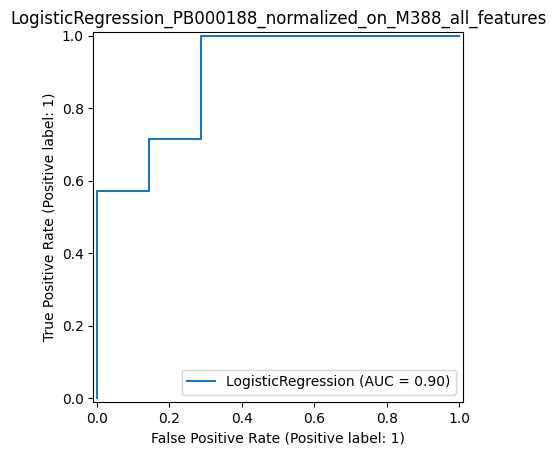

In [153]:
RocCurveDisplay.from_estimator(log_none, X_test, y_test)
plt.title("LogisticRegression_{}_normalized_on_{}_{}".format(plate, normalization, features))
plt.savefig("ROC-AUC_{}_normalized_on_{}_{}_used.png".format(plate, normalization, features), dpi=100, bbox_inches='tight')
plt.show()

### Inspecting coefficients (feature contribution to decision)

In [154]:
coefs = pd.Series(log_none.coef_.ravel(), index=X.columns)
nonzero = coefs[coefs != 0].sort_values(key=np.abs, ascending=False)
print("\nNon-zero LogisticRegression coefficients (sorted by |coef|):")
print(nonzero)


Non-zero LogisticRegression coefficients (sorted by |coef|):
Correlation_K_illumSYTO_illumPHAandWGA_cytoplasm        -0.653143
Granularity_16_illumMITO_cytoplasm                      -0.504080
Correlation_K_illumPHAandWGA_illumSYTO_cytoplasm         0.498527
Granularity_9_illumPHAandWGA_cytoplasm                  -0.471010
Granularity_4_illumCONC_cytoplasm                        0.452231
                                                           ...   
Location_CenterMassIntensity_Y_illumHOECHST_cytoplasm    0.001080
Intensity_MassDisplacement_illumPHAandWGA_cytoplasm     -0.000706
Correlation_RWC_illumPHAandWGA_illumSYTO_cytoplasm       0.000495
Intensity_MaxIntensityEdge_illumCONC_cytoplasm           0.000421
AreaShape_Zernike_5_1_cytoplasm                          0.000398
Length: 640, dtype: float64


### Store results in a DataFrame

In [155]:
coef_df = (
    pd.DataFrame({'feature': X.columns, 'coef': log_none.coef_.ravel()})
      .assign(abs_coef=lambda d: d['coef'].abs())
      .sort_values('abs_coef', ascending=False)
      .reset_index(drop=True))

coef_df.to_csv("Feature_contribution_P387_{}_normalized_on_{}_{}.csv".format(plate, normalization, features), index=False)

print("\nTop 20 features by |coef|:")
print(coef_df.head(10))


Top 20 features by |coef|:
                                             feature      coef  abs_coef
0   Correlation_K_illumSYTO_illumPHAandWGA_cytoplasm -0.653143  0.653143
1                 Granularity_16_illumMITO_cytoplasm -0.504080  0.504080
2   Correlation_K_illumPHAandWGA_illumSYTO_cytoplasm  0.498527  0.498527
3             Granularity_9_illumPHAandWGA_cytoplasm -0.471010  0.471010
4                  Granularity_4_illumCONC_cytoplasm  0.452231  0.452231
5  RadialDistribution_ZernikePhase_illumSYTO_8_4_...  0.439630  0.439630
6  Intensity_IntegratedIntensity_illumPHAandWGA_c...  0.438800  0.438800
7               Granularity_2_illumHOECHST_cytoplasm  0.432005  0.432005
8  Intensity_MinIntensityEdge_illumPHAandWGA_cyto...  0.431133  0.431133
9                    AreaShape_Zernike_8_6_cytoplasm -0.430036  0.430036


### Plotting the data

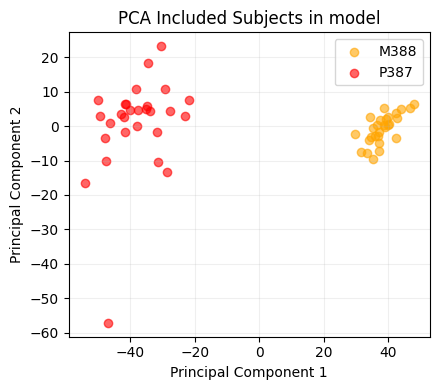

In [156]:
# Perform PCA to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Create a scatter plot of the two principal components, color-coded by class
df_plot = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_plot['target'] = y.values

# Adding the target and person_plate columns for plotting
if len(df_plot) != len(df):
    raise ValueError("Lengths differ; cannot merge row-wise.")

# Adding the information
df_plot['person_plate'] = df['person_plate'].to_numpy()
df_plot['target']       = df['target'].to_numpy()
df_plot['person_plate'] = df_plot['person_plate'].astype(str).str[:4] # Retaining only first 4 character for P287 and M388

plt.figure(figsize=(4.5,4))
colors = {0: 'orange', 1: 'red'}
for label in df_plot['target'].unique():
    subset = df_plot[df_plot['target'] == label]
    legend_label = subset['person_plate'].mode()[0]
    plt.scatter(subset['PC1'], subset['PC2'],
                label=legend_label,
                alpha=0.6, color=colors[label])

plt.title('PCA Included Subjects in model')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.savefig("PCA_modling_{}_normalized_on_{}_{}_used.png".format(plate, normalization, features), dpi=300, bbox_inches='tight')
plt.show()

# Preparing data for prediction

In [157]:
persons_to_keep = ['P387']#, 'M388', 'F389'] #, 'F389']
treated = data[data['person_plate'].str.contains('|'.join(persons_to_keep))]
treated.head(3)

,WellID,plate,batch_id,person_plate,comp_conc,AreaShape_Area_cytoplasm,AreaShape_BoundingBoxArea_cytoplasm,AreaShape_BoundingBoxMaximum_X_cytoplasm,AreaShape_BoundingBoxMaximum_Y_cytoplasm,AreaShape_BoundingBoxMinimum_X_cytoplasm,...,RadialDistribution_ZernikePhase_illumSYTO_8_0_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_8_2_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_8_4_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_8_6_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_8_8_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_1_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_3_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_5_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_7_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_9_cytoplasm
1,PB000188_A03,PB000188,HY-15136,P387_PB000188,HY-15136_4.0,4.122417,0.219324,0.908775,-1.835055,0.835260,...,-20.0,-0.587930,1.238131,1.294947,-0.631829,-1.999400,1.404031,2.141365,-1.479475,3.480793
2,PB000188_A04,PB000188,PHB000001,P387_PB000188,PHB000001_0.1,12.191764,5.517065,0.646240,-0.614277,0.440957,...,0.0,-0.851160,0.161159,-0.169089,1.692752,1.701895,-0.481200,1.177919,0.591259,1.150220
4,PB000188_A06,PB000188,HY-Y0272,P387_PB000188,HY-Y0272_10.0,16.197113,9.045836,0.838869,0.618942,0.708843,...,0.0,-0.525283,-1.965248,1.078546,0.218977,0.806525,1.409608,-1.156605,4.123809,-1.082309


In [158]:
treated.comp_conc.unique()

array(['HY-15136_4.0', 'PHB000001_0.1', 'HY-Y0272_10.0', 'PHB000018_1.0',
       'PHB000016_3.0', 'HY-15136_HY-15315_4.0_1.0', 'HY-15315_10.0',
       'HY-15136_HY-15315_4.0_0.4', 'PHB000006_1.0', 'PHB000004_10.0',
       'HY-101012_1.0', 'HY-15315_0.4', 'PHB000015_3.0', 'PHB000010_40.0',
       'SIGMA-428020_10.0', 'HY-15315_HY-15136_10.0_1.0',
       'SIGMA-TA9H98772C6C_10.0', 'HY-15315_HY-15136_4.0_1.0',
       'HY-15136_HY-15315_10.0_10.0', 'HY-15315_4.0', 'HY-101012_3.0',
       'SIGMA-TA9H98772C6C_1.0', 'PHB000012_10.0', 'SIGMA-428020_1.0',
       'HY-101012_10.0', 'HY-15315_30.0', 'PHB000010_10.0',
       'HY-15315_HY-15136_1.0_0.4', 'PHB000018_3.0', 'PHB000010_4.0',
       'HY-15136_1.0', 'HY-15315_HY-15136_4.0_0.4',
       'SIGMA-TA9H98772C6C_3.0', 'HY-15315_1.0',
       'HY-15315_HY-15136_0.4_1.0', 'PHB000012_4.0', 'PHB000006_10.0',
       'PHB000019_1.0', 'HY-15136_0.1', 'HY-15136_0.4', 'PHB000016_1.0',
       'HY-18258_3.0', 'HY-Y0272_3.0', 'HY-15315_0.1', 'HY-Y0272_1.0',
 

### Dropping the DMSO data

In [159]:
treated_ready = treated[~treated['comp_conc'].astype(str).str.contains('PHB000001_0.1', na=False)].copy()
#treated_ready

### Dropping classical controls

In [160]:
#compounds_to_keep = ["PHB000016", "PHB000018", "PHB000004", "PHB000010", "PHB000008",  "PHB000019", "PHB000012", "PHB000002", "PHB000015", 'PHB000001', 'HY-15136', 'HY-15315']
#treated_ready = data[~data['comp_conc'].str.contains('|'.join(compounds_to_keep))] # EXCLUDE
treated_ready = treated

### Subsetting F389 data

In [161]:
#persons_to_keep2 = ['M388'] 
#treated2 = data_treatments[data_treatments['person_plate'].str.contains('|'.join(persons_to_keep2))]
#treated2.head(3)

### Retaining only DMSO data

In [162]:
##treated_ready2 = treated2[treated2['comp_conc'].astype(str).str.contains('PHB000001_0.1', na=False)].copy() # Retain DMSO
#treated_ready2 = treated2[~treated2['comp_conc'].astype(str).str.contains('PHB000001_0.1', na=False)].copy() # Non DMSO
#print("treated_ready2: ", treated_ready2.shape)
#treated_ready2.head(3)

### Appending P387 and M388 data

In [163]:
#treated_ready = pd.concat([treated_ready, treated_ready2], ignore_index=True)

### Wells per subject

In [164]:
class_counts = treated_ready['person_plate'].value_counts()
print(class_counts)

person_plate
P387_PB000188    144
Name: count, dtype: int64


# Classifying data

In [165]:
# features used during training
feats = feature_cols if 'feature_cols' in locals() else list(X.columns)

# align features
for c in feats:
    if c not in treated_ready.columns:
        treated_ready[c] = 0.0
X_t = treated_ready[feats].apply(pd.to_numeric, errors='coerce').fillna(0.0)

# predict
proba = log_none.predict_proba(X_t)[:, 1]
pred = (proba >= 0.5).astype(int)

# results
results = treated_ready.copy()
results['pred_class'] = np.where(pred == 1, 'P387', 'M388')
results['proba_P387'] = proba
results['proba_P387'] = np.round(proba, 2)  # shorten decimals to 2

print('Total samples:', len(results))
print('\nPredicted class counts:')
print(results['pred_class'].value_counts(dropna=False))
print('\nPreview:')
print(results[['pred_class','proba_P387']].head())

# optional evaluation if labels exist
if 'person_plate' in treated_ready.columns:
    y_true = treated_ready['person_plate'].astype(str).str.startswith('P387').astype(int)
    all_labels = [0, 1]  # 0=M388, 1=P387

    # Always pass labels so shapes are consistent even if only one class is present
    print('Confusion Matrix:', confusion_matrix(y_true, pred, labels=all_labels))

    # Classification report with explicit labels and safe handling for zero divisions
    print('Classification Report:', classification_report(
        y_true, pred,
        labels=all_labels,
        target_names=['M388','P387'],
        zero_division=0
    ))

    # Helpful notes if only one class is present
    if np.unique(y_true).size < 2:
        print('Note: Only one class present in ground truth (y_true); some metrics are not informative.')
    if np.unique(pred).size < 2:
        print('Note: Model predicted only one class for all samples; precision/recall for the other class will be zero.')

    # ROC-AUC is undefined if y_true has a single class
    if np.unique(y_true).size == 2:
        try:
            print('ROC-AUC:', f"{roc_auc_score(y_true, proba):.4f}")
        except Exception as e:
            print('ROC-AUC not computed:', e)
    else:
        print('ROC-AUC: skipped (only one class present in y_true).')
else:
    print('No ground-truth labels found in `treated`; skipped evaluation metrics.')

### Saving to file
outfile = "Classification_results_summary_{}_normalized_on_{}_{}.txt".format(plate, normalization, features)

with open(outfile, "w") as f:

    if 'person_plate' in treated_ready.columns:
        y_true = treated_ready['person_plate'].astype(str).str.startswith('P387').astype(int)
        all_labels = [0, 1]  # 0=M388, 1=P387

        # Confusion matrix
        cm = confusion_matrix(y_true, pred, labels=all_labels)
        f.write("=== Confusion Matrix for classified samples ===\n")
        f.write(str(cm) + "\n\n")

        # Classification report
        report = classification_report(
            y_true, pred,
            labels=all_labels,
            target_names=['M388', 'P387'],
            zero_division=0
        )
        f.write("=== Classification Report ===\n")
        f.write(report + "\n")

        # Notes for missing classes
        if np.unique(y_true).size < 2:
            f.write("Note: Only one class present in y_true; metrics may be unreliable.\n")
        if np.unique(pred).size < 2:
            f.write("Note: Model predicted only one class for all samples.")

        # ROC-AUC if possible
        if np.unique(y_true).size == 2:
            try:
                auc = roc_auc_score(y_true, proba)
                f.write(f"\n=== ROC-AUC ===\n{auc:.4f}\n")
            except Exception as e:
                f.write(f"\nROC-AUC not computed: {e}\n")
        else:
            f.write("\nROC-AUC skipped (only one class present in y_true).\n")

    else:
        f.write("No ground-truth labels found in `treated`; skipped evaluation metrics.\n")

Total samples: 144

Predicted class counts:
pred_class
P387    141
M388      3
Name: count, dtype: int64

Preview:
  pred_class  proba_P387
1       P387         1.0
2       P387         1.0
4       P387         1.0
6       P387         1.0
7       P387         1.0
Confusion Matrix: [[  0   0]
 [  3 141]]
Classification Report:               precision    recall  f1-score   support

        M388       0.00      0.00      0.00         0
        P387       1.00      0.98      0.99       144

    accuracy                           0.98       144
   macro avg       0.50      0.49      0.49       144
weighted avg       1.00      0.98      0.99       144

Note: Only one class present in ground truth (y_true); some metrics are not informative.
ROC-AUC: skipped (only one class present in y_true).


In [166]:
# ==== FULL list of probabilities 
#print('\nPredictions (all rows):')
#print(results[['pred_class','proba_P387']].to_string(index=True))

## Visualizing classification with compound name and conc

### Load qc data where metadata for compound names is included

In [167]:
meta_data = pd.read_csv('/share/data/analyses/martin/036_Progeria_LoBa_48h_72h/004_analysis/PB000188_LoBa_72h_family4_PCA_tSNE_median_M388_norm_AreaShape/PB000188_LoBa_78h_family4_qc_filtered_site_level_median.csv')
#meta_data.head(2)
#last_cols = meta_data.columns[-45:]
#print(list(last_cols))
meta_data.compound_name.unique()

array(['Baricitinib', 'Lonafarnib', 'Dimethyl Sulfoxide', 'Ca-074 Me',
       'Saccharin', 'Berberine Chloride', 'Fluphenazine Dihydrochloride',
       'Repaglinide', 'Lonafarnib_Baricitinib',
       'Tetrandrine | Fanchinine', 'Oxibendazole', 'Fenbendazole',
       'Etoposide', 'NPPB | 5-Nitro-2-(3-phenylpropylamino)benzoic acid',
       'Baricitinib_Lonafarnib', 'Rapamycin', 'Metoclopramide',
       'Latrunculin B', 'CA-074Me', 'Amperozide', 'Staurosporine',
       'Staurosporine | Antibiotic AM-2282', 'Sorbitol', 'Cycloheximide',
       'Rotenone', 'BerbBerine chloride', 'Paclitaxel'], dtype=object)

In [168]:
meta_data.comp_conc.unique()

array(['HY-15315_0.1', 'HY-15136_4.0', 'PHB000001_0.1', 'PHB000016_10.0',
       'HY-Y0272_10.0', 'PHB000002_1.0', 'PHB000008_10.0',
       'PHB000018_1.0', 'PHB000016_3.0', 'HY-15136_10.0',
       'HY-15136_HY-15315_4.0_1.0', 'HY-15315_10.0', 'PHB000015_10.0',
       'HY-B0299_1.0', 'PHB000006_3.0', 'HY-15136_HY-15315_4.0_0.4',
       'PHB000006_1.0', 'PHB000004_10.0', 'HY-15136_0.1', 'HY-101012_1.0',
       'PHB000004_3.0', 'PHB000002_10.0', 'HY-15315_0.4', 'HY-15136_0.4',
       'HY-15315_HY-15136_4.0_10.0', 'PHB000015_3.0', 'HY-15315_1.0',
       'HY-10219_1.0', 'PHB000010_40.0', 'SIGMA-428020_10.0',
       'HY-15136_1.0', 'HY-100350_3.0', 'HY-15315_HY-15136_10.0_1.0',
       'SIGMA-TA9H98772C6C_10.0', 'HY-15315_HY-15136_4.0_1.0',
       'PHB000013_1.0', 'HY-15141_10.0', 'HY-15136_HY-15315_10.0_10.0',
       'HY-15315_4.0', 'HY-101012_3.0', 'SIGMA-TA9H98772C6C_1.0',
       'PHB000012_10.0', 'SIGMA-428020_1.0', 'HY-101012_10.0',
       'HY-15315_30.0', 'PHB000010_10.0', 'HY-15136_30

### Creating a raw dictionary

In [169]:
raw_dict = dict(zip(meta_data['comp_conc'], meta_data['compound_name']))
#raw_dict

### New dictionary that is appending concentrations to the compound names

In [170]:
new_dict = {}

for comp_conc, compound_name in raw_dict.items():
    # extract all numeric concentrations in order
    concs = re.findall(r'\d+\.\d+', comp_conc)

    # split compound names at "_" -> gives list with same ordering
    names = compound_name.split("_")

    # attach concentration to each compound name
    combined = [f"{n} {c}" for n, c in zip(names, concs)]

    # join with "_" again if mixture, or remain single
    new_dict[comp_conc] = " & ".join(combined)

#new_dict
list(new_dict.items())[:16]

[('HY-15315_0.1', 'Baricitinib 0.1'),
 ('HY-15136_4.0', 'Lonafarnib 4.0'),
 ('PHB000001_0.1', 'Dimethyl Sulfoxide 0.1'),
 ('PHB000016_10.0', 'Ca-074 Me 10.0'),
 ('HY-Y0272_10.0', 'Saccharin 10.0'),
 ('PHB000002_1.0', 'Berberine Chloride 1.0'),
 ('PHB000008_10.0', 'Fluphenazine Dihydrochloride 10.0'),
 ('PHB000018_1.0', 'Repaglinide 1.0'),
 ('PHB000016_3.0', 'Ca-074 Me 3.0'),
 ('HY-15136_10.0', 'Lonafarnib 10.0'),
 ('HY-15136_HY-15315_4.0_1.0', 'Lonafarnib 4.0 & Baricitinib 1.0'),
 ('HY-15315_10.0', 'Baricitinib 10.0'),
 ('PHB000015_10.0', 'Tetrandrine | Fanchinine 10.0'),
 ('HY-B0299_1.0', 'Oxibendazole 1.0'),
 ('PHB000006_3.0', 'Fenbendazole 3.0'),
 ('HY-15136_HY-15315_4.0_0.4', 'Lonafarnib 4.0 & Baricitinib 0.4')]

### Classification results plot with new compound names

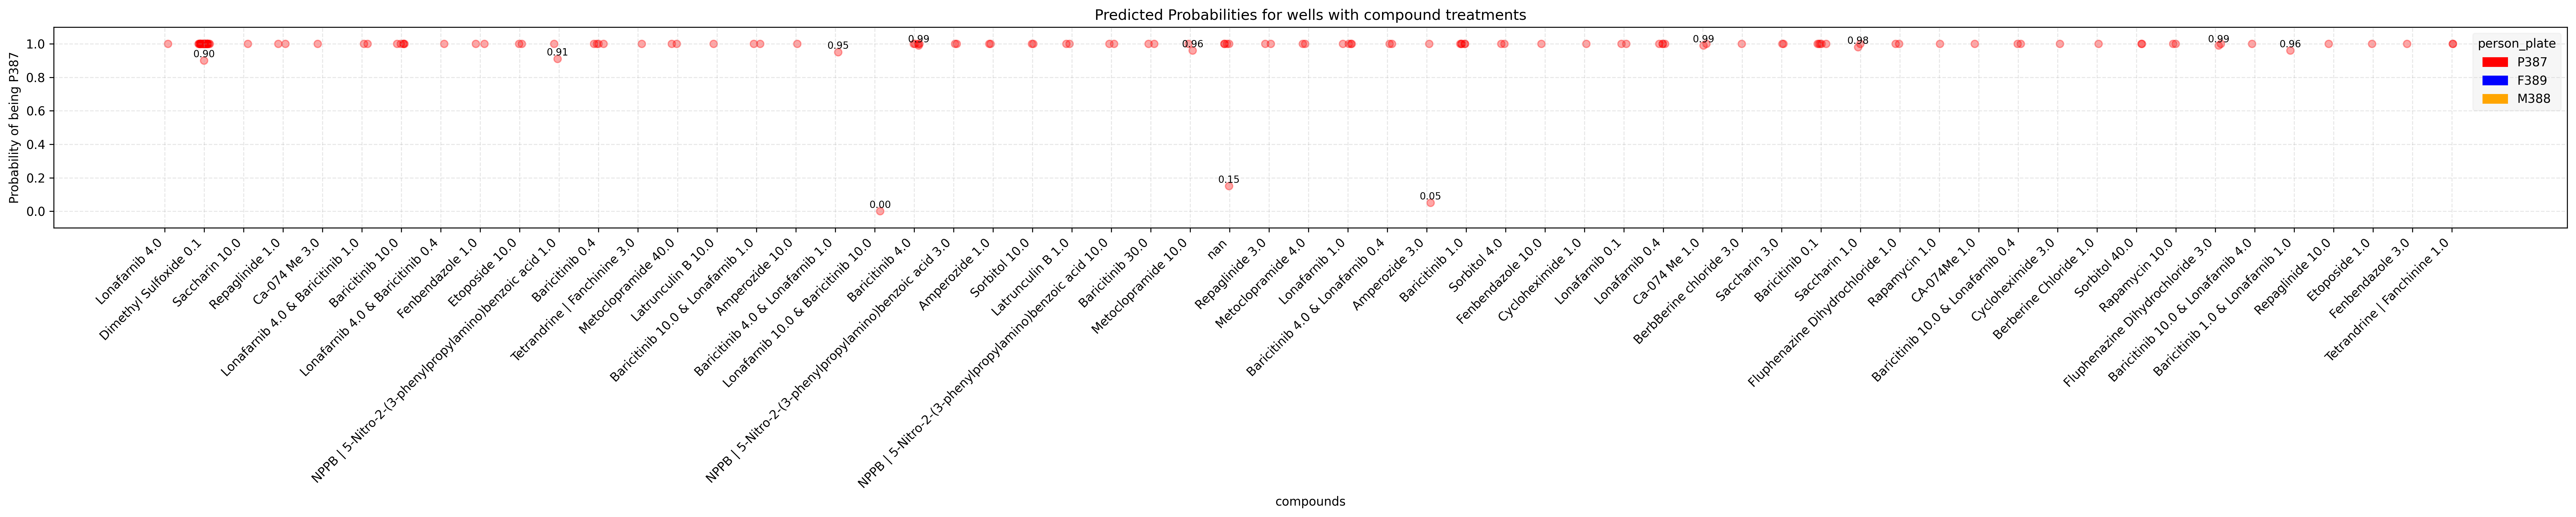

In [171]:
# Ensure required columns exist in `results`
required_cols = {'person_plate', 'proba_P387', 'comp_conc'}
missing = required_cols - set(results.columns)
if missing:
    raise KeyError(f"Missing columns in results: {missing}")

# Add a color column based on person_plate prefix
results['color'] = results['person_plate'].apply(
    lambda x: 'red' if str(x).startswith('P387') else (
        'blue' if str(x).startswith('F389') else 'orange')
)

### Replace comp_conc labels with new_dict values
comp = results['comp_conc'].astype(str)

### Use new_dict to map comp_conc → enriched label
enriched_labels = comp.map(new_dict)

### Unique enriched labels (keep order of first occurrence)
labels = pd.unique(enriched_labels)

# Map each enriched label to an x-axis index
label_to_x = {lab: i for i, lab in enumerate(labels)}
x = enriched_labels.map(label_to_x)

### Jittering the multiple compound dots
rng = np.random.default_rng(42)
x_jitter = x + rng.uniform(-0.15, 0.15, size=len(x))

### Dynamic width of the plot
fig_w = max(9, 0.5 * len(labels))
plt.figure(figsize=(fig_w, 6), dpi=300)

### Actual plot
plt.scatter(x_jitter, results['proba_P387'], c=results['color'], alpha=0.35)

plt.title('Predicted Probabilities for wells with compound treatments')
plt.xlabel('compounds')
plt.ylabel('Probability of being P387')
plt.ylim(-0.1, 1.1)
plt.grid(True, linestyle='--', alpha=0.3)

for xi, yi in zip(x_jitter, results['proba_P387']):
    if yi < 1.00:
        plt.text(xi, yi + 0.02, f"{yi:.2f}", fontsize=8, ha='center', color='black')

# Use enriched labels for tick labels
plt.xticks(ticks=range(len(labels)), labels=labels, rotation=45, ha='right')

legend_patches = [
    mpatches.Patch(color='red', label='P387'),
    mpatches.Patch(color='blue', label='F389'),
    mpatches.Patch(color='orange', label='M388')
]
plt.legend(handles=legend_patches, title='person_plate', loc='best',
           framealpha=0.2, facecolor='lightgray', edgecolor='lightgray')

plt.tight_layout()
plt.savefig("Classification_probabilities_{}_normalized_on_{}_{}.png".format(plate, normalization, features), dpi=300, bbox_inches='tight')
plt.show()

### Saving out a high resolution figure Original comp_conc for compounds

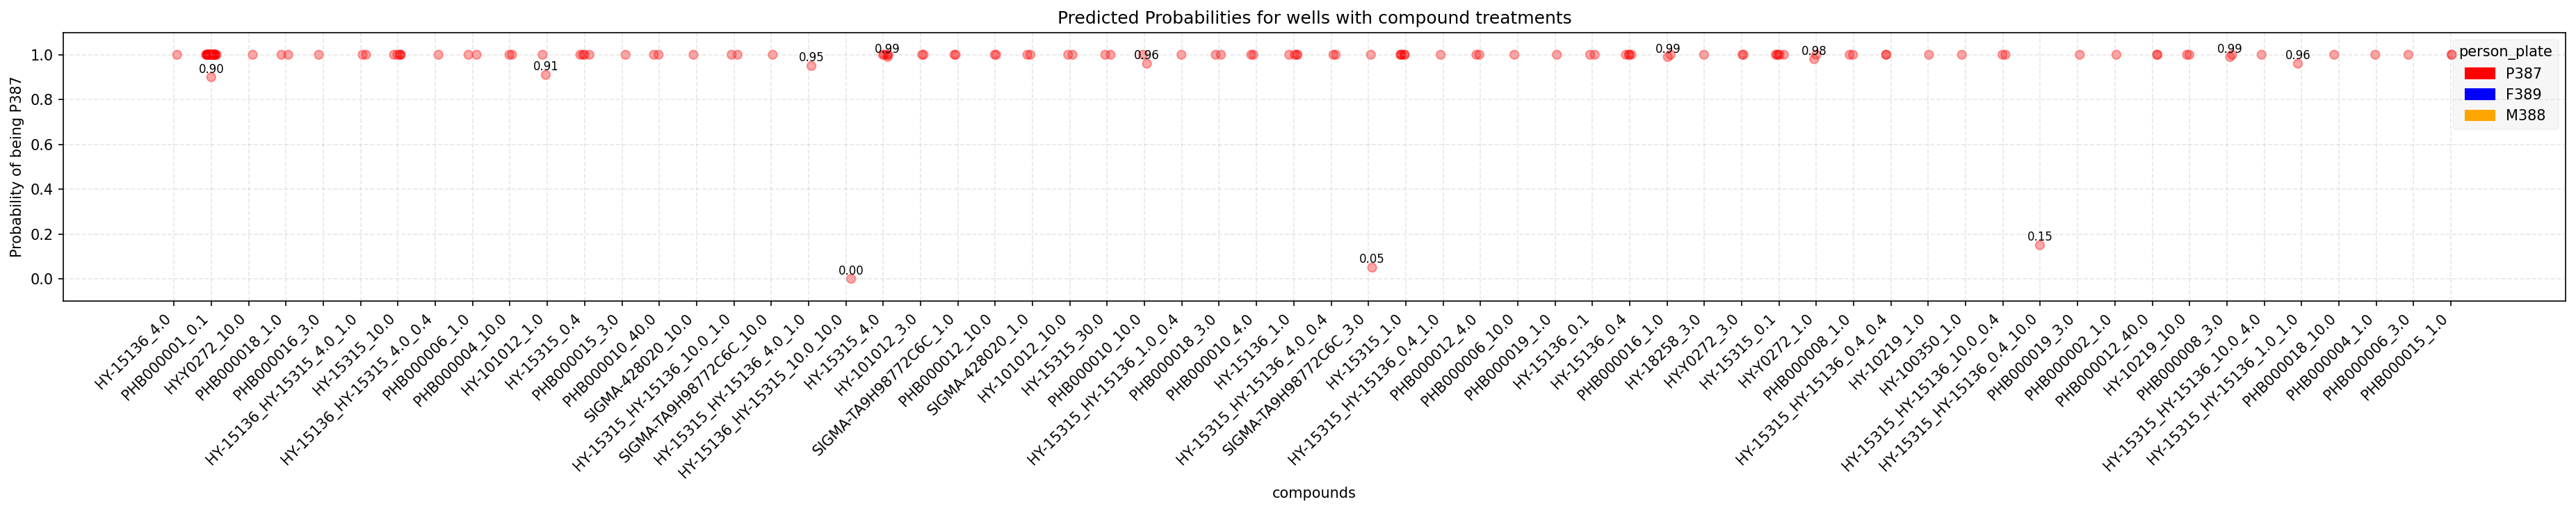

In [172]:
# Ensure required columns exist in `results`
required_cols = {'person_plate', 'proba_P387', 'comp_conc'}
missing = required_cols - set(results.columns)
if missing:
    raise KeyError(f"Missing columns in results: {missing}")

# Add a color column based on person_plate prefix
results['color'] = results['person_plate'].apply(
    lambda x: 'red' if str(x).startswith('P387') else (
        'blue' if str(x).startswith('F389') else 'orange')
)

# Map comp_conc to x positions (categorical → numeric codes)
comp = results['comp_conc'].astype(str)
labels = pd.unique(comp)  # preserve first-seen order
label_to_x = {lab: i for i, lab in enumerate(labels)}
x = comp.map(label_to_x)

# Optional jitter to reduce overlap when many points share the same comp_conc
rng = np.random.default_rng(42)
x_jitter = x + rng.uniform(-0.15, 0.15, size=len(x))

# Dynamic figure width based on number of labels (keeps it readable)
fig_w = max(1, 0.4 * len(labels))
plt.figure(figsize=(fig_w, 5), dpi=150)
plt.scatter(x_jitter, results['proba_P387'], c=results['color'], alpha=0.35)
plt.title('Predicted Probabilities for wells with compound treatments')
plt.xlabel('compounds')
plt.ylabel('Probability of being P387')
plt.ylim(-0.1, 1.1)
plt.grid(True, linestyle='--', alpha=0.3)

# Annotate probabilities below 1.00
for xi, yi in zip(x_jitter, results['proba_P387']):
    if yi < 1.00:
        plt.text(xi, yi + 0.02, f"{yi:.2f}", fontsize=8, ha='center', color='black')

# Set categorical tick labels
plt.xticks(ticks=range(len(labels)), labels=labels, rotation=45, ha='right')

# Add legend manually
legend_patches = [
    mpatches.Patch(color='red', label='P387'),
    mpatches.Patch(color='blue', label='F389'),
    mpatches.Patch(color='orange', label='M388')
]
plt.legend(handles=legend_patches, title='person_plate', loc='best', framealpha=0.2, facecolor='lightgray', edgecolor='lightgray')
plt.tight_layout()
plt.savefig("Classification_probabilities_{}_normalized_on_{}_{}_comp_conc.png".format(plate, normalization, features), dpi=300, bbox_inches='tight')
plt.show()

# Fancy Confusion Matrix

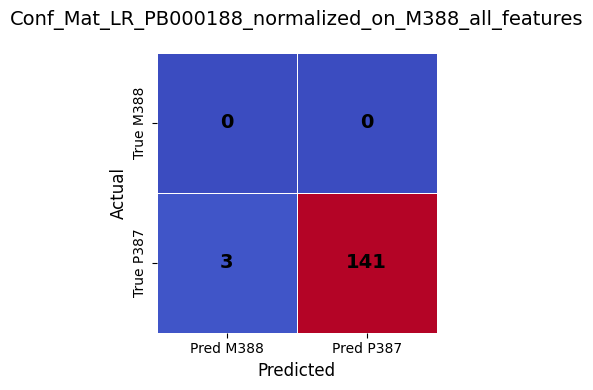

In [173]:
if 'person_plate' in treated_ready.columns:
    y_true = treated_ready['person_plate'].astype(str).str.startswith('P387').astype(int)
    cm = confusion_matrix(y_true, pred, labels=[0,1])
    cm_df = pd.DataFrame(cm, index=['True M388','True P387'], columns=['Pred M388','Pred P387'])

    plt.figure(figsize=(5,4))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='coolwarm', cbar=False, square=True,
                linewidths=.5, annot_kws={"size":14, "weight":"bold", "color":"black"})
    plt.title('Conf_Mat_LR_{}_normalized_on_{}_{}'.format(plate, normalization, features), fontsize=14, pad=20)
    plt.ylabel('Actual', fontsize=12)
    plt.xlabel('Predicted', fontsize=12)
    plt.tight_layout()
    plt.savefig("ConfusionMatrix_{}_normalized_on_{}_{}.png".format(plate, normalization, features), dpi=200, bbox_inches='tight')
    plt.show()

### Listing classification results

In [174]:
# Map comp_conc → enriched compound names from new_dict
results['compound_name'] = results['comp_conc'].map(new_dict)

# Build display dataframe with added column
display_df = results[['WellID','person_plate', 'comp_conc', 'compound_name', 'pred_class', 'proba_P387']]
display_df = display_df.sort_values(by='proba_P387')
display_df.to_csv("Classification_results_{}_normalized_on_{}_{}.csv".format(plate, normalization, features), index=False)

print('\n=== Classification Summary All Wells ===')
display_df


=== Classification Summary All Wells ===


,WellID,person_plate,comp_conc,compound_name,pred_class,proba_P387
38,PB000188_C13,P387_PB000188,HY-15136_HY-15315_10.0_10.0,Lonafarnib 10.0 & Baricitinib 10.0,M388,0.00
74,PB000188_E10,P387_PB000188,SIGMA-TA9H98772C6C_3.0,Amperozide 3.0,M388,0.05
150,PB000188_J03,P387_PB000188,HY-15315_HY-15136_0.4_10.0,NaN,M388,0.15
247,PB000188_P12,P387_PB000188,PHB000001_0.1,Dimethyl Sulfoxide 0.1,P387,0.90
17,PB000188_B01,P387_PB000188,HY-101012_1.0,NPPB | 5-Nitro-2-(3-phenylpropylamino)benzoic ...,P387,0.91
...,...,...,...,...,...,...
18,PB000188_B04,P387_PB000188,HY-15315_0.4,Baricitinib 0.4,P387,1.00
20,PB000188_B10,P387_PB000188,PHB000001_0.1,Dimethyl Sulfoxide 0.1,P387,1.00
22,PB000188_B12,P387_PB000188,PHB000015_3.0,Tetrandrine | Fanchinine 3.0,P387,1.00
25,PB000188_B18,P387_PB000188,PHB000010_40.0,Metoclopramide 40.0,P387,1.00


### Displaying only specific persons

In [175]:
display_df = display_df[display_df['person_plate'].astype(str).str.startswith(('P387'))].copy() #M 388 F389
display_df = display_df.sort_values(by='proba_P387')
display_df.to_csv("Classification_results_specific_sample_{}_normalized_on_{}_{}.csv".format(plate, normalization, features), index=False)
display_df

,WellID,person_plate,comp_conc,compound_name,pred_class,proba_P387
38,PB000188_C13,P387_PB000188,HY-15136_HY-15315_10.0_10.0,Lonafarnib 10.0 & Baricitinib 10.0,M388,0.00
74,PB000188_E10,P387_PB000188,SIGMA-TA9H98772C6C_3.0,Amperozide 3.0,M388,0.05
150,PB000188_J03,P387_PB000188,HY-15315_HY-15136_0.4_10.0,NaN,M388,0.15
247,PB000188_P12,P387_PB000188,PHB000001_0.1,Dimethyl Sulfoxide 0.1,P387,0.90
17,PB000188_B01,P387_PB000188,HY-101012_1.0,NPPB | 5-Nitro-2-(3-phenylpropylamino)benzoic ...,P387,0.91
...,...,...,...,...,...,...
235,PB000188_O16,P387_PB000188,PHB000001_0.1,Dimethyl Sulfoxide 0.1,P387,1.00
238,PB000188_O22,P387_PB000188,HY-15315_4.0,Baricitinib 4.0,P387,1.00
242,PB000188_P06,P387_PB000188,HY-10219_10.0,Rapamycin 10.0,P387,1.00
245,PB000188_P10,P387_PB000188,HY-101012_1.0,NPPB | 5-Nitro-2-(3-phenylpropylamino)benzoic ...,P387,1.00


### Instances with different classification or with correct classification with probability < 0.90

In [176]:
### Extract first 4 characters of person_plate
prefix = display_df['person_plate'].astype(str).str[:4]

### Condition 1: prefix does NOT match pred_class
cond_mismatch = prefix != display_df['pred_class'].astype(str)

### Condition 2: prefix matches pred_class BUT probability < 0.90
cond_lowprob = (prefix == display_df['pred_class'].astype(str)) & (display_df['proba_P387'] < 0.95)

### Combined subset
df_mismatch = display_df[cond_mismatch | cond_lowprob]
df_mismatch = df_mismatch.sort_values(by='proba_P387')
df_mismatch.to_csv("Classification_results_deviations_for_P387_{}_normalized_on_{}_{}.csv".format(plate, normalization, features), index=False)
df_mismatch

,WellID,person_plate,comp_conc,compound_name,pred_class,proba_P387
38,PB000188_C13,P387_PB000188,HY-15136_HY-15315_10.0_10.0,Lonafarnib 10.0 & Baricitinib 10.0,M388,0.00
74,PB000188_E10,P387_PB000188,SIGMA-TA9H98772C6C_3.0,Amperozide 3.0,M388,0.05
150,PB000188_J03,P387_PB000188,HY-15315_HY-15136_0.4_10.0,NaN,M388,0.15
247,PB000188_P12,P387_PB000188,PHB000001_0.1,Dimethyl Sulfoxide 0.1,P387,0.90
17,PB000188_B01,P387_PB000188,HY-101012_1.0,NPPB | 5-Nitro-2-(3-phenylpropylamino)benzoic ...,P387,0.91


### End